# SHO Fitting in Pytorch

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload

import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

from m3_learning.optimizers.AdaHessian import AdaHessian
from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
from m3_learning.util.preprocessing import global_scaler
from m3_learning.nn.random import random_seed
from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.dataset import BE_Dataset


# from m3_learning.viz.printing import printer
# printing = printer(basepath = './figures/')

2023-03-30 22:32:32.381914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 22:32:32.497815: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-30 22:32:32.932319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-30 22:32:32.932364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Loads Data

In [3]:
# Sets path to file
path = r"./"

# instantiate the dataset object
dataset = BE_Dataset("./data_file_raw.h5", testing=True)

# print the contents of the file
dataset.print_be_tree()

# sets size for resampling
dataset.resample_bins = 80

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ complex
      -------
      ├ imag
      ├ imag_resampled
      ├ imag_resampled_scaled
      ├ real
      ├ real_resampled
      ├ real_resampled_scaled
    ├ magnitude_spectrum


In [4]:
# # create a list for parameters
# fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# # flatten parameters list into numpy array
# fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# # exclude the R2 parameter
# params = fit_results_list.reshape(-1, 5)[:, 0:4]

# # scale the parameters (now takes only 4 parameters, excluding the R2)
# params_scaler = StandardScaler()
# scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model. 

Note: This uses the results from the least squares fitting LSQF results. 

In [5]:
dataset.complex_spectrum_real_resampled_scaled
dataset.complex_spectrum_imag_resampled_scaled

spectra number 543


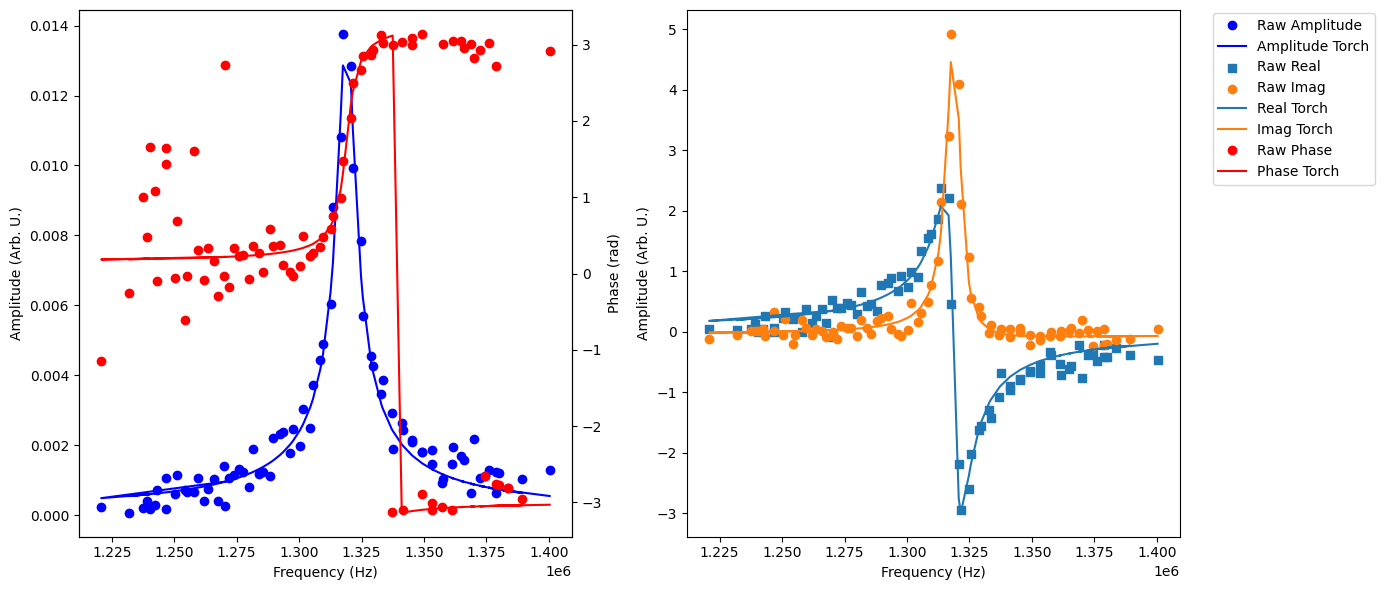

In [10]:
dataset.LSQF_torch_function_comparison()

## Pytorch Model

### Model Architecture

![](Assets\Figures\model_architecture_sho.png)

### Builds the Model

In [7]:
class SHO_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        # fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(26, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # output shape - samples, (real, imag), frequency
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(x, (n, 2, 128))  # batch size, (real, imag), timesteps
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.
        embedding = self.hidden_embedding(encoded)  # output is 4 parameters

        # corrects the scaling of the parameters
        unscaled_param = (
            embedding * torch.tensor(params_scaler.var_[0:4] ** 0.5).cuda()
            + torch.tensor(params_scaler.mean_[0:4]).cuda()
        )

        # passes to the pytorch fitting function
        fits = SHO_fit_func_torch(unscaled_param, wvec_freq, device="cuda")

        # extract and return real and imaginary
        real = torch.real(fits)
        real_scaled = (real - torch.tensor(scaler_real.mean).cuda()) / torch.tensor(
            scaler_real.std
        ).cuda()
        imag = torch.imag(fits)
        imag_scaled = (imag - torch.tensor(scaler_imag.mean).cuda()) / torch.tensor(
            scaler_imag.std
        ).cuda()
        out = torch.stack((real_scaled, imag_scaled), 2)
        return out

### Test/Train Split

In [8]:
# builds the test train split for the data
data_train, data_test, params_train, params_test = train_test_split(
    scaled_data, scaled_params, test_size=0.7, random_state=42
)

# conduct the inverse transform to get the original data
params_test_unscaled = params_scaler.inverse_transform(params_test)

### Training

In [9]:
# sets the model and DataType
model = SHO_Model().cuda().double()

# views the structure of the model
print(model)

SHO_Model(
  (hidden_x1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(7,), stride=(1,))
    (1): SELU()
    (2): Conv1d(8, 6, kernel_size=(7,), stride=(1,))
    (3): SELU()
    (4): Conv1d(6, 4, kernel_size=(5,), stride=(1,))
    (5): SELU()
  )
  (hidden_xfc): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): SELU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SELU()
  )
  (hidden_x2): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (2): SELU()
    (3): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (4): SELU()
    (5): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (6): SELU()
    (7): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (8): SELU()
    (9): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (10): SELU()
    (11): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (12): SELU()
    (13): AvgPool1d(kernel_size=(2,), 

In [10]:
# create subdirectory for saving a model
if os.path.exists("Trained Models/SHO Fitter"):
    pass
else:
    make_folder(f"{path}Trained Models/SHO Fitter/")

In [11]:
# Note that the seed will behave differently on different hardware targets (GPUs)
random_seed(seed=42)

torch.cuda.empty_cache()

loss_func = torch.nn.MSELoss()
batch_size = 200

# uncomment the code below if you want to try Adahessian
optimizer = torch.optim.Adam(model.parameters())
# optimizer = AdaHessian(model.parameters(), lr=0.1) #0.1

# instantiate the dataloader
train_dataloader = DataLoader(data_train, batch_size=batch_size)

# sets the number of epochs
epochs = 5

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in train_dataloader:

        pred = model(train_batch.double().cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.double().cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num
    torch.save(model, 'Trained Models/SHO Fitter/model.pt')
    torch.save(model.state_dict(), 'Trained Models/SHO Fitter/model.pth')

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


c:\Conda\envs\m3_learning\lib\site-packages\torch\autograd\__init__.py:204: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 1/5, recon loss = 0.06813851
--- 25.33688521385193 seconds ---
epoch : 2/5, recon loss = 0.04311499
--- 23.48956322669983 seconds ---
epoch : 3/5, recon loss = 0.04270260
--- 23.34066367149353 seconds ---
epoch : 4/5, recon loss = 0.04250039
--- 23.559620141983032 seconds ---
epoch : 5/5, recon loss = 0.04238562
--- 23.50656032562256 seconds ---


### Calculate Inference Time

In [12]:
torch.cuda.empty_cache()

bs = int(.5e4)
train_dataloader_valid = DataLoader(data_train, batch_size=bs)

# Computes the inference time
computeTime(model, next(iter(train_dataloader_valid)).double(), batch_size=bs)

Avg execution time (ms): 0.018797


### Validation Reconstruction

In [13]:
# prediction of reconstructions
batch_size = 10000
train_dataloader = DataLoader(data_test, batch_size=batch_size)

# preallocate the predictions
num_elements = len(train_dataloader.dataset)
num_batches = len(train_dataloader)
predictions = torch.zeros_like(torch.tensor(data_test))

# compute the predictions
for i, train_batch in enumerate(train_dataloader):
    start = i * batch_size
    end = start + batch_size

    if i == num_batches - 1:
        end = num_elements

    pred_batch = model(train_batch.double().cuda())
    predictions[start:end] = pred_batch.cpu().detach()

    del pred_batch
    del train_batch
    torch.cuda.empty_cache()

In [14]:
# save the predictions into a file
h5_f.create_dataset("predictions", data=predictions)
h5_f.close()